In [1]:
import xarray as xr
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
from xskillscore import crps_ensemble

In [3]:
module_path = '/home/jupyter-ayoub'
if module_path not in sys.path:
    sys.path.append(module_path)
from Transformer import StackedTransformer

In [4]:
def fair_crps_ensemble(observations, forecasts, axis=0):

    # Convert inputs to numpy arrays if they're not already
    forecasts = np.asarray(forecasts)
    observations = np.asarray(observations)
    
    if axis != 1:
        forecasts = np.moveaxis(forecasts, axis, 1)
    
    # Get number of ensemble members
    m = forecasts.shape[1]
    
    # Calculate dxy: sum of absolute differences between forecasts and observations
    # Add a dimension to observations to allow broadcasting
    observations_expanded = np.expand_dims(observations, axis=1)
    dxy = np.sum(np.abs(forecasts - observations_expanded), axis=1)
    
    # Calculate dxx: sum of absolute differences between all pairs of ensemble members
    # Add dimensions to enable broadcasting for pairwise differences
    forecast_i = np.expand_dims(forecasts, axis=2)  # [batch, ens, 1, ...]
    forecast_j = np.expand_dims(forecasts, axis=1)  # [batch, 1, ens, ...]
    dxx = np.sum(np.abs(forecast_i - forecast_j), axis=(1, 2))
    
    # Calculate CRPS using the kernel approximation formula
    crps = dxy / m - dxx / (m * (m - 1) * 2)
    
    return crps

### Data preparation

In [5]:
#ssrd6
test_rfcs=xr.open_dataset("/home/jupyter-ayoub/data/test/test_reforecast.nc")
obs=xr.open_dataset("/home/jupyter-ayoub/data/test/test_observation.nc")

In [6]:
#w100
test_rfcs=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_reforecast.nc")
obs=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_observation.nc")

In [7]:
test_rfcs=test_rfcs
obs=obs

In [ ]:
print(test_rfcs)

In [ ]:
print(obs)

In [ ]:
print(list(test_rfcs.data_vars))

In [8]:
target='w100_obs'  
obs=obs[target]
test_rfcs=test_rfcs.drop_vars([ 'z', 'sd', 'mx2t6', 'mn2t6','u', 'w700', 'p10fg6', 'v'])
#['sd', 'mx2t6', 'mn2t6', 'q', 'tp6', 'ssr6', 'str6', 'ssrd6', 'strd6']

In [9]:
#add orography as a variable
oro=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/oro.nc") 
dims={'time' : test_rfcs['time'],
       'number': test_rfcs['number'],
       'step': test_rfcs['step']}
xds_oro=oro.expand_dims(time=dims['time'], number=dims['number'],step=dims['step'])
dummy_oro=xr.Dataset(coords=dims)
final_oro=xds_oro.broadcast_like(dummy_oro)

In [10]:
fcs_10=xr.merge([test_rfcs,final_oro])
dummy=xr.merge([test_rfcs,final_oro])

In [11]:
#normalizing
min_max_values={"t2m":(235, 304), "z": (48200, 58000), "t":(240, 299), "u10": (-13., 11.),"v10": (-30,35), "tcc": (0., 1.0),"sd":(0,8),"mx2t6":(230,320),"mn2t6":(225,315),"v":(-50,55), "w100":(0,50),"w10":(0,30), "u100": (-35,45), "u": (-45,60),"v100":(-40,45), "w700": (0,60), "p10fg6": (0,60), "oro":(-400,2800)}
# Function to normalize using vectorized operations
def minmax_normalize(ds, min_max_values):
    for var in ds.data_vars:
        if var in min_max_values:
            min_val, max_val = min_max_values[var]
            ds[var] = (ds[var] - min_val) / (max_val - min_val)
    return ds

print(minmax_normalize(dummy,min_max_values))

<xarray.Dataset> Size: 2GB
Dimensions:        (time: 209, number: 11, step: 20, latitude: 32, longitude: 33)
Coordinates:
  * latitude       (latitude) float64 256B 53.5 53.25 53.0 ... 46.25 46.0 45.75
  * longitude      (longitude) float64 264B 2.5 2.75 3.0 ... 10.0 10.25 10.5
  * number         (number) int64 88B 0 1 2 3 4 5 6 7 8 9 10
    surface        float64 8B 0.0
  * time           (time) datetime64[ns] 2kB 2017-01-02 ... 2018-12-31
    valid_time     (time, step) datetime64[ns] 33kB ...
    year           int64 8B 20
  * step           (step) float64 160B 6.0 12.0 18.0 24.0 ... 108.0 114.0 120.0
    isobaricInhPa  float64 8B 700.0
Data variables:
    t2m            (time, number, step, latitude, longitude) float32 194MB 0....
    t              (time, number, step, latitude, longitude) float32 194MB 0....
    u10            (time, number, step, latitude, longitude) float32 194MB 0....
    v10            (time, number, step, latitude, longitude) float32 194MB 0....
    tcc     

In [12]:
#normalizing
min_max_values={"t2m":(235, 304), "z": (48200, 58000), "t":(240, 299), "u10": (-13., 11.),"v10": (-30,35), "tcc": (0., 1.0),"sd":(0,8),"mx2t6":(230,320),"mn2t6":(225,315),"v":(-50,55), "w100":(0,50),"w10":(0,30), "u100": (-35,45), "u": (-45,60),"v100":(-40,45), "w700": (0,60), "p10fg6": (0,60), "oro":(-400,2800)}
# Function to normalize using vectorized operations
def minmax_normalize(ds, min_max_values):
    for var in ds.data_vars:
        if var in min_max_values:
            min_val, max_val = min_max_values[var]
            ds[var] = (ds[var] - min_val) / (max_val - min_val)
    return ds

def z_normalize(ds):
    for var in ds.data_vars:
        ds[var] = ds[var].copy()  # Ensure the variable is writable
        
        for t in range(len(ds["time"])):  # Loop over time dimension
            mean = ds[var].isel(time=t).mean()
            std = ds[var].isel(time=t).std()
            ds[var].loc[dict(time=ds["time"][t])] = (ds[var].isel(time=t) - mean) / std

    return ds




dummy_norm=minmax_normalize(dummy,min_max_values)
fcs_norm=dummy_norm

In [13]:
%reload_ext autoreload
model =  StackedTransformer(num_blocks=4, n_data_shape=(20, 32, 33, 10), n_heads=8,mlp_mult=4,projection_channels=64)

### Actual testing

In [14]:
#this is where the last run is stored 
#checkpoint_path = '/home/jupyter-ayoub/results/Transformerweights/w100/epochs50predictors15CRPSlambda0.02k3.3.pth'
checkpoint_path = '/home/jupyter-ayoub/results/Transformerweights/w100/epochs50predictors10CRPSlambda0.02k3.3.pth'
# Load the checkpoint
checkpoint = torch.load(checkpoint_path, weights_only=False)
model_state_dict = checkpoint['model']
new_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(new_state_dict)
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  1551649


In [15]:
#turn the normalized reforecasts into a tensor
fcs_norm_whole= fcs_norm.to_array(dim='variable')
print(fcs_norm_whole.sizes)
rearranged_10= fcs_norm_whole.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')
fcs_whole_tensor=torch.tensor(rearranged_10.values)
print(fcs_whole_tensor.shape) 

Frozen({'variable': 10, 'time': 209, 'number': 11, 'step': 20, 'latitude': 32, 'longitude': 33})
torch.Size([209, 11, 20, 32, 33, 10])


In [16]:
#same for unnormalized data, because I need them for the rescaling 
fcs_array_10 =fcs_10.to_array(dim='variable')
fcs_rearranged_10= fcs_array_10.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')
fcs_whole_notnorm_tensor=torch.tensor(fcs_rearranged_10.values)
print(fcs_whole_notnorm_tensor.shape)

torch.Size([209, 11, 20, 32, 33, 10])


In [18]:
import torch
postpro_10_whole = torch.empty((209,11,20,32,33,10))

# Apply model in chunks of 10
with torch.no_grad():
    for i in range(0, 209, 20):
        # Get the end index for this chunk
        end = min(i + 20, 209)  # Ensure we don't go out of bounds

        # Apply the model to the chunk and store in the corresponding location in postpro_10_whole
        postpro_10_whole[i:end] = model(fcs_whole_tensor[i:end])

In [26]:
MBM_one=np.empty((209,11,20,32,33),dtype=float)
for i in range(20):
    mbm1=np.load(f"/home/jupyter-ayoub/ClassicalMBM/resultsClassicalMBM/{target}/MBM_{target}_{i}.npy")
    MBM_one[:,:,i,:,:]=mbm1.squeeze()

In [27]:
ensemble_one = postpro_10_whole[...,0]
values_tar = fcs_whole_notnorm_tensor[:,:,:,:,:,0] #torch.Size([26, 11, 32, 33])
scale_std, scale_mean= torch.std_mean(values_tar, dim=1, unbiased=True)
scaled_ensemble_one=(ensemble_one * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)).permute(1, 0, 2, 3, 4)

In [28]:
# Define coordinates with member first
coords_forecast = {
    'member': test_rfcs['number'].rename({'number': 'member'}),
    'time': obs['time'],
    'step': obs['step'],
    'latitude': obs['latitude'],
    'longitude': obs['longitude'],
}


# Define dimensions with member first
dims_forecast = ('member', 'time', 'step', 'latitude', 'longitude')

# Convert numpy arrays to xarray DataArray with the specified order
print("MBM_one shape:", MBM_one.shape)

MBM_one=xr.DataArray(np.transpose(MBM_one,(1,0,2,3,4)), coords=coords_forecast, dims=dims_forecast)
full_ensemble_one= xr.DataArray(scaled_ensemble_one, coords=coords_forecast, dims=dims_forecast)
# Compute mean and std across the member dimension
mean_one = full_ensemble_one.mean(dim='member')
std_one = full_ensemble_one.std(dim='member')

# Adjust raw_fcs to have 'member' first
raw_fcs = test_rfcs.rename({'number': 'member'})
raw_fcs = raw_fcs.transpose('member', 'time', 'step', 'latitude', 'longitude')
raw_mean=raw_fcs.mean(dim='member')
raw_std=raw_fcs.std(dim='member')

MBM_one shape: (209, 11, 20, 32, 33)


In [30]:
#ALL ENSEMBLES

Tformer_one=full_ensemble_one

MBM_one = MBM_one
Raw = raw_fcs['w100']
obs=obs.squeeze()

In [37]:
import xskillscore as xs

output_dir = "/home/jupyter-ayoub/results/CRPS"
os.makedirs(output_dir, exist_ok=True)

# Load observations (assuming you have them)
observations = obs

# Dictionary of ensemble forecasts
ensembles = {
    #"Tformer_one": Tformer_one,
    #"MBM_one": MBM_one,
    "Raw": Raw
}

# Process each ensemble
for name, ensemble in ensembles.items():
    print(f"Processing {name}...")
    
    obs_broadcast = observations
    
    # Initialize arrays to store CRPS values
    # Assuming we compute CRPS for each leadtime
    n_leadtimes = ensemble.shape[2]
    gaussian_crps = np.zeros(n_leadtimes)
    fair_crps = np.zeros(n_leadtimes)
    
    # Compute CRPS for each leadtime
    for lt in range(n_leadtimes):
        
        # Extract data for this leadtime
        ensemble_lt = ensemble[:, :, lt, :, :]  # (member, time, lat, lon)
        obs_lt = obs_broadcast[:, lt, :, :]  # (time, lat, lon)
        
        # Convert to xarray for xs.crps_gaussian
        ensemble_xr = xr.DataArray(
            ensemble_lt, 
            dims=["member", "time", "latitude", "longitude"]
        )
        obs_xr = xr.DataArray(
            obs_lt,
            dims=["time", "latitude", "longitude"]
        )
        
        # Compute Gaussian CRPS
        # Mean and standard deviation along member dimension
        mean = ensemble_xr.mean(dim="member")
        std = ensemble_xr.std(dim="member")
        g_crps = xs.crps_gaussian(obs_xr, mean, std)
        gaussian_crps[lt] = g_crps.mean().values
        
        # Compute fair ensemble CRPS
        f_crps = fair_crps_ensemble(obs_lt, ensemble_lt, axis=0)
        fair_crps[lt] = np.mean(f_crps)
    
    # Save results
    np.save(f"{output_dir}/{name}_gaussian_crps.npy", gaussian_crps)
    np.save(f"{output_dir}/{name}_fair_crps.npy", fair_crps)
    

print("All CRPS computations complete!")

Processing Raw...
All CRPS computations complete!


In [34]:
np.load("/home/jupyter-ayoub/results/CRPS/Tformer_one_gaussian_crps.npy")

array([275.2751254 , 280.52240265, 278.06538851, 275.29777635,
       275.21578507, 280.62484523, 278.18221946, 275.43589093,
       275.39780891, 280.65873562, 278.21642356, 275.41971054,
       275.25843996, 280.44417023, 278.03589388, 275.2360601 ,
       275.1406045 , 280.48781424, 278.04502858, 275.33111653])

In [44]:
CRPS_TF_1 = np.load("/home/jupyter-ayoub/results/CRPS/Tformer_one_fair_crps.npy")
CRPS_TF_1_G = np.load("/home/jupyter-ayoub/results/CRPS/Tformer_one_gaussian_crps.npy")
CRPS_MBM_1 = np.load("/home/jupyter-ayoub/results/CRPS/MBM_one_fair_crps.npy")
CRPS_MBM_1_G = np.load("/home/jupyter-ayoub/results/CRPS/MBM_one_gaussian_crps.npy")
CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/Raw_fair_crps.npy")
CRPS_OG_G=np.load("/home/jupyter-ayoub/results/CRPS/Raw_gaussian_crps.npy")
meanOG=np.mean(CRPS_OG)
meanOG_g=np.mean(CRPS_OG_G)
meanmbm_1=np.mean(CRPS_MBM_1)
meanmbm_1_g=np.mean(CRPS_MBM_1_G)
meantf_1=np.mean(CRPS_TF_1)
meantf_1_g=np.mean(CRPS_TF_1_G)
print(meanOG,meanOG_g,meanmbm_1,meanmbm_1_g,meantf_1,meantf_1_g)

0.8017302466657906 0.8415076326158826 0.7479000733562511 0.7932205512950055 277.3142092621654 277.3145620121871


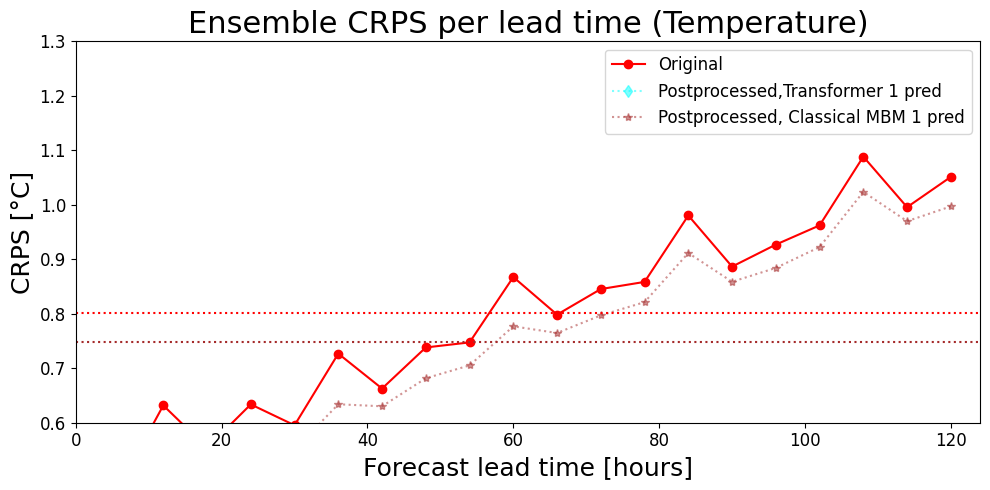

In [46]:
#CRPS WITHOUT GAUSSIAN ASSUMPTION
Leadtimes=obs.step.values
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 5))
plt.plot(Leadtimes, CRPS_OG, color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF_1, color='cyan',linestyle=':', marker='d' ,alpha=0.5,label='Postprocessed,Transformer 1 pred')
plt.plot(Leadtimes, CRPS_MBM_1, color='brown',linestyle=':', marker='*',alpha=0.5, label='Postprocessed, Classical MBM 1 pred')


plt.axhline(y=meanOG, color='red',linestyle=':')
plt.axhline(y=meantf_1, color='cyan',linestyle=':')
plt.axhline(y=meanmbm_1, color='brown',linestyle=':')

# Set title and labels
plt.title('Ensemble CRPS per lead time (wind speed 100m)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [metres per second.]', fontsize=18)

# Set y-axis limits and x-axis ticks
plt.xlim(0,124)
plt.ylim(0.6,1.3)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig("CRPS_leadtime_all.png")
plt.show()

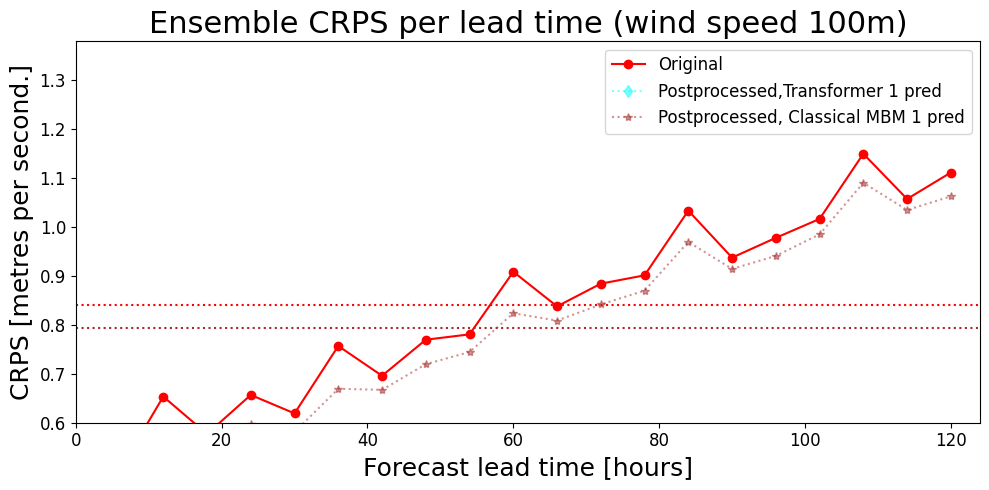

In [48]:
#CPRS WITH GAUSSIAN ASSUMPTION
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 5))
plt.plot(Leadtimes, CRPS_OG_G, color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF_1_G, color='cyan',linestyle=':', marker='d' ,alpha=0.5,label='Postprocessed,Transformer 1 pred')
plt.plot(Leadtimes, CRPS_MBM_1_G, color='brown',linestyle=':', marker='*',alpha=0.5, label='Postprocessed, Classical MBM 1 pred')


plt.axhline(y=meanOG_g, color='red',linestyle=':')
plt.axhline(y=meantf_1_g, color='cyan',linestyle=':')
plt.axhline(y=meanmbm_1_g, color='brown',linestyle=':')

# Set title and labels
plt.title('Ensemble CRPS per lead time (wind speed 100m)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [metres per second.]', fontsize=18)

# Set y-axis limits and x-axis ticks
plt.xlim(0,124)
plt.ylim(0.6,1.38)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig("CRPS_leadtime_all.png")
plt.show()

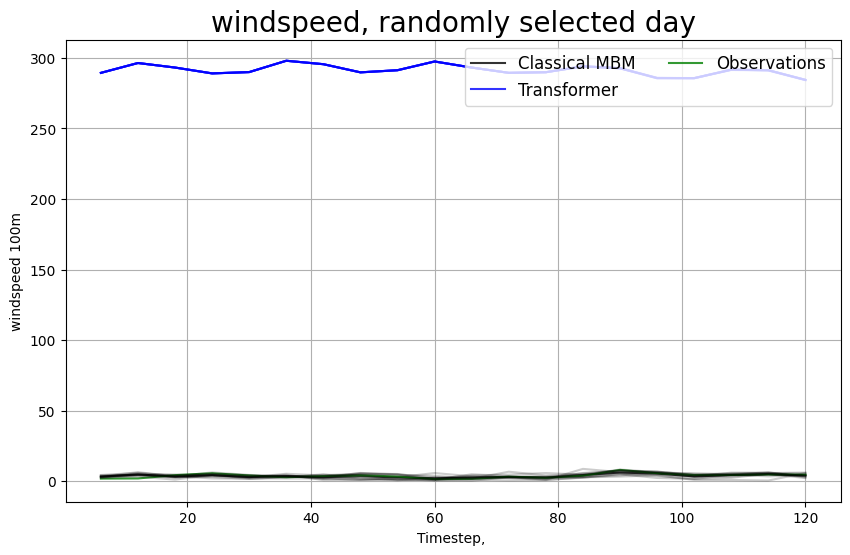

In [51]:
#Example of an ensemble
np.random.seed(156)  # For reproducibility #156
random_time = np.random.randint(0, Tformer_one.sizes["time"])
random_lat = np.random.randint(0, Tformer_one.sizes["latitude"])
random_lon = np.random.randint(0, Tformer_one.sizes["longitude"])

# Extract data for all 11 ensemble members at the chosen location
TF = Tformer_one[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
MBM = MBM_one[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
OBS = obs[random_time, :, random_lat, random_lon] 
RAW = Raw[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
# Plot all ensemble members as a function of step
plt.figure(figsize=(10, 6))
#plt.plot(MBM_one.step, np.mean(RAW,axis=0),color='red',alpha=0.8,label="Raw Forecasts")
plt.plot(MBM_one.step, np.mean(MBM,axis=0),color='black',alpha=0.8,label="Classical MBM")
plt.plot(Tformer_one.step, np.mean(TF,axis=0),color='blue',alpha=0.8,label="Transformer")
plt.plot(MBM_one.step, OBS,color='green',alpha=0.8,label="Observations")
for member in range(TF.sizes["member"]):
    plt.plot(Tformer_one.step, TF[member, :],color='blue',alpha=0.2)
    plt.plot(MBM_one.step, MBM[member, :],color='black',alpha=0.2)
    #plt.plot(raw_fcs.step, RAW[member,:],color='red',alpha=0.2)

# Formatting the plot
plt.xlabel("Timestep, ")
plt.ylabel("windspeed 100m")
plt.title("windspeed, randomly selected day",fontsize="20")
plt.legend(loc="upper right", fontsize=12, ncol=2)
plt.grid(True)
plt.show()